# INTRO

This notebook makes predictions for the Santander Customer Satisfaction competition at Kaggle.

More about the dataset and the competition can be found here:
https://www.kaggle.com/c/santander-customer-satisfaction

In this notebook multiple Feature Selection and Feature Engineering steps are applied in order to prepare the data.

Than two of the most modern gradient boosted descision tree models: XGboost and LightGBM are applied to make predictions.

The parameters used when training the models are derived using Gridsearch.

The models quality is evaluated on a Development Set before submission. The scores used are AUC on the first place and accuracy on the second place.

# Load Data & Short EDA

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None, 'display.max_rows', 100)

In [34]:
df = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')
df.shape, X_test.shape

((76020, 371), (75818, 370))

In [35]:
df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

In [36]:
#Droping the ID column, since it has no predictive power 
df.drop('ID', axis=1, inplace=True)

In [37]:
#Splitting into Train and Dev Set
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(df.iloc[:,:-1], df.iloc[:,-1] , test_size=0.05, random_state = 0)
X_train.shape, X_dev.shape, y_train.shape, y_dev.shape,

((72219, 369), (3801, 369), (72219,), (3801,))

In [38]:
# Check Datatypes -> only nummerical features
X_train.dtypes.value_counts()

int64      258
float64    111
dtype: int64

In [39]:
#Check for Missing Values
missing_values_veatures = [var for var in df.columns if df[var].isnull().sum()>0]
missing_values_veatures

[]

    -> There are no empty cells in the dataset

In [40]:
# Get initial columns
discrete = [var for var in X_train.columns if X_train[var].dtype != 'O' and X_train[var].nunique() < 50]
continuous = [var for var in X_train.columns if X_train[var].dtype != 'O' and var not in discrete]

print('Discrete variables are {}'.format(len(discrete)))
print(discrete)
print('')
print('Continuous variables are {}'.format(len(continuous)))
print(continuous)
print('')

Discrete variables are 284
['imp_op_var40_efect_ult1', 'imp_op_var40_efect_ult3', 'ind_var1_0', 'ind_var1', 'ind_var2_0', 'ind_var2', 'ind_var5_0', 'ind_var5', 'ind_var6_0', 'ind_var6', 'ind_var8_0', 'ind_var8', 'ind_var12_0', 'ind_var12', 'ind_var13_0', 'ind_var13_corto_0', 'ind_var13_corto', 'ind_var13_largo_0', 'ind_var13_largo', 'ind_var13_medio_0', 'ind_var13_medio', 'ind_var13', 'ind_var14_0', 'ind_var14', 'ind_var17_0', 'ind_var17', 'ind_var18_0', 'ind_var18', 'ind_var19', 'ind_var20_0', 'ind_var20', 'ind_var24_0', 'ind_var24', 'ind_var25_cte', 'ind_var26_0', 'ind_var26_cte', 'ind_var26', 'ind_var25_0', 'ind_var25', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var29_0', 'ind_var29', 'ind_var30_0', 'ind_var30', 'ind_var31_0', 'ind_var31', 'ind_var32_cte', 'ind_var32_0', 'ind_var32', 'ind_var33_0', 'ind_var33', 'ind_var34_0', 'ind_var34', 'ind_var37_cte', 'ind_var37_0', 'ind_var37', 'ind_var39_0', 'ind_var40_0', 'ind_var40', 'ind_var41_0', 'ind_var41', 'ind_var39',

In [41]:
# Check for cardinality 
for var in discrete:
    print('')
    print(var)
    print(X_train[var].value_counts()/X_train.shape[0])


imp_op_var40_efect_ult1
0.00       0.999502
900.00     0.000069
1800.00    0.000055
600.00     0.000042
60.00      0.000042
120.00     0.000028
270.00     0.000028
300.00     0.000028
450.00     0.000014
330.00     0.000014
930.00     0.000014
210.00     0.000014
6600.00    0.000014
1020.00    0.000014
420.00     0.000014
1710.00    0.000014
74.28      0.000014
1200.00    0.000014
870.00     0.000014
87.90      0.000014
750.00     0.000014
150.00     0.000014
180.00     0.000014
Name: imp_op_var40_efect_ult1, dtype: float64

imp_op_var40_efect_ult3
0.00       0.999405
900.00     0.000069
120.00     0.000055
1800.00    0.000055
330.00     0.000028
600.00     0.000028
300.00     0.000028
60.00      0.000028
960.00     0.000028
87.90      0.000014
6600.00    0.000014
450.00     0.000014
270.00     0.000014
150.00     0.000014
1621.26    0.000014
210.00     0.000014
3810.00    0.000014
420.00     0.000014
3000.00    0.000014
720.00     0.000014
180.00     0.000014
1710.00    0.000014
74.2

0     0.998615
3     0.000706
6     0.000332
9     0.000138
12    0.000097
15    0.000069
27    0.000014
21    0.000014
18    0.000014
Name: num_var17, dtype: float64

num_var18_0
0    0.999972
3    0.000028
Name: num_var18_0, dtype: float64

num_var18
0    0.999972
3    0.000028
Name: num_var18, dtype: float64

num_var20_0
0    0.996344
3    0.003656
Name: num_var20_0, dtype: float64

num_var20
0    0.997286
3    0.002714
Name: num_var20, dtype: float64

num_var24_0
0    0.957643
3    0.042177
6    0.000166
9    0.000014
Name: num_var24_0, dtype: float64

num_var24
0    0.962101
3    0.037857
6    0.000042
Name: num_var24, dtype: float64

num_var26_0
0     0.975145
3     0.020867
6     0.003212
9     0.000554
12    0.000152
15    0.000028
33    0.000014
27    0.000014
21    0.000014
Name: num_var26_0, dtype: float64

num_var26
0     0.975145
3     0.020867
6     0.003212
9     0.000554
12    0.000152
15    0.000028
33    0.000014
27    0.000014
21    0.000014
Name: num_var26, dtype: f

0             0.999972
9999999999    0.000028
Name: delta_imp_amort_var18_1y3, dtype: float64

delta_imp_amort_var34_1y3
0             0.999972
9999999999    0.000028
Name: delta_imp_amort_var34_1y3, dtype: float64

delta_imp_aport_var13_1y3
 0.000000e+00    0.972570
-1.000000e+00    0.022210
 1.000000e+10    0.004846
-3.333333e-01    0.000028
-5.000000e-01    0.000028
 4.000000e+00    0.000028
-1.973684e-01    0.000014
 1.222222e+00    0.000014
 1.000000e+00    0.000014
 1.538462e-01    0.000014
-2.910826e-01    0.000014
-4.995000e-01    0.000014
-6.666667e-01    0.000014
-3.494898e-01    0.000014
-7.602877e-01    0.000014
 4.000000e-01    0.000014
 5.500000e+00    0.000014
 1.605039e-01    0.000014
 2.333092e+00    0.000014
-8.333333e-01    0.000014
-9.038462e-01    0.000014
 1.777778e+00    0.000014
 1.181818e+00    0.000014
-1.000000e-01    0.000014
 1.445714e+00    0.000014
-8.000000e-01    0.000014
-9.090909e-02    0.000014
Name: delta_imp_aport_var13_1y3, dtype: float64

delta_i

0    0.914247
1    0.085753
Name: ind_var9_ult1, dtype: float64

ind_var43_emit_ult1
0    0.933203
1    0.066797
Name: ind_var43_emit_ult1, dtype: float64

ind_var43_recib_ult1
0    0.870602
1    0.129398
Name: ind_var43_recib_ult1, dtype: float64

var21
0        0.988576
900      0.003116
1800     0.002783
4500     0.001232
3000     0.001094
7200     0.000789
3600     0.000678
1500     0.000402
6000     0.000374
2700     0.000305
9000     0.000194
1200     0.000166
5400     0.000042
2400     0.000042
18000    0.000028
3300     0.000028
4200     0.000028
5100     0.000028
2100     0.000028
7500     0.000014
6600     0.000014
5700     0.000014
10500    0.000014
30000    0.000014
Name: var21, dtype: float64

num_var2_0_ult1
0    1.0
Name: num_var2_0_ult1, dtype: float64

num_var2_ult1
0    1.0
Name: num_var2_ult1, dtype: float64

num_aport_var13_hace3
0     0.977361
3     0.020770
6     0.001274
9     0.000346
12    0.000180
24    0.000028
18    0.000028
15    0.000014
Name: num_aport_va

0     0.998726
3     0.000997
6     0.000249
15    0.000014
12    0.000014
Name: num_sal_var16_ult1, dtype: float64

num_var43_emit_ult1
0      0.933203
3      0.039325
6      0.014207
9      0.006106
12     0.002894
15     0.001399
18     0.000872
21     0.000568
24     0.000305
27     0.000305
33     0.000208
30     0.000125
36     0.000083
45     0.000083
42     0.000055
39     0.000042
51     0.000042
60     0.000042
57     0.000028
102    0.000014
84     0.000014
48     0.000014
75     0.000014
180    0.000014
69     0.000014
54     0.000014
66     0.000014
Name: num_var43_emit_ult1, dtype: float64

num_var43_recib_ult1
0      0.870602
3      0.071366
6      0.031640
9      0.011659
12     0.005317
15     0.002894
18     0.001939
21     0.001163
24     0.000789
27     0.000443
30     0.000332
33     0.000318
36     0.000263
39     0.000263
45     0.000125
48     0.000111
51     0.000111
63     0.000083
54     0.000083
42     0.000069
66     0.000042
69     0.000042
93     0.000042

    -> Great proportion of the data is concentrated in one or 2 values
    -> Many of the features seem quasi-constant

var3


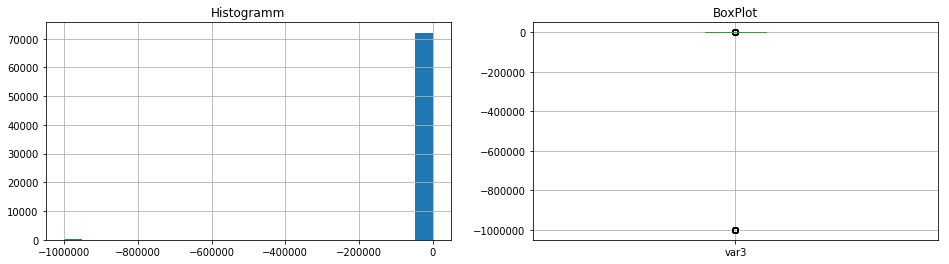

var15


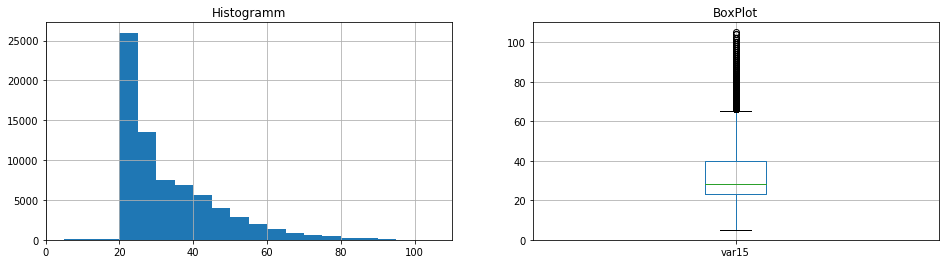

imp_ent_var16_ult1


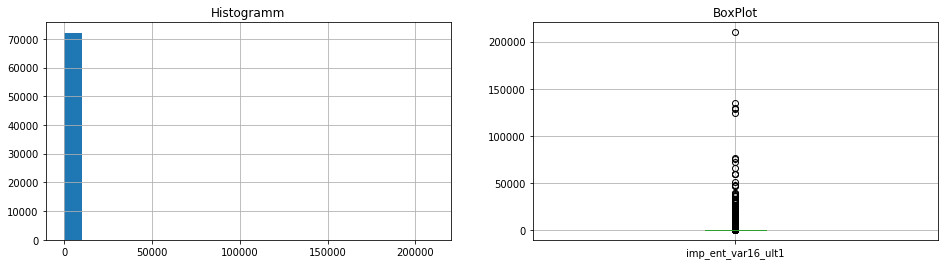

imp_op_var39_comer_ult1


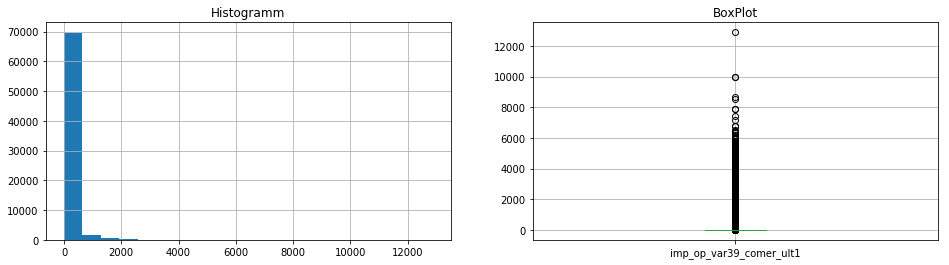

imp_op_var39_comer_ult3


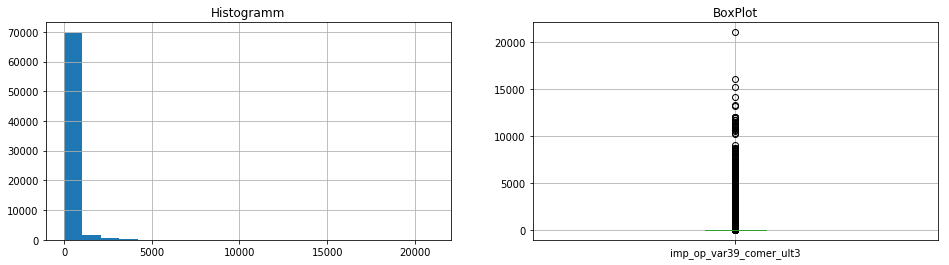

imp_op_var40_comer_ult1


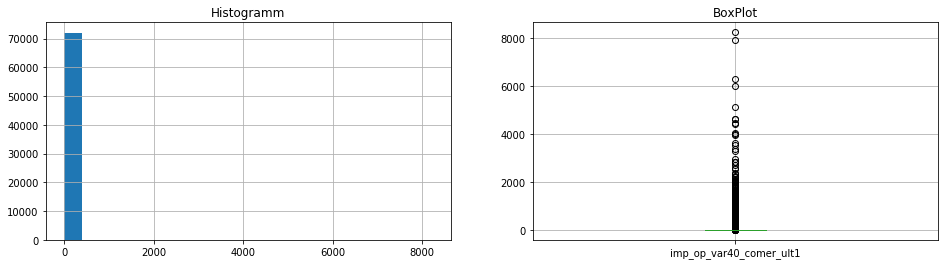

imp_op_var40_comer_ult3


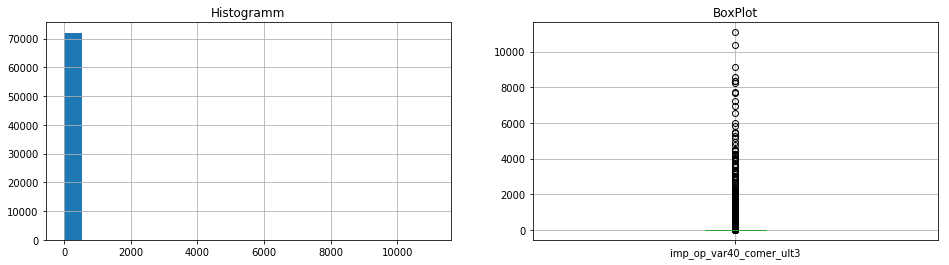

imp_op_var40_ult1


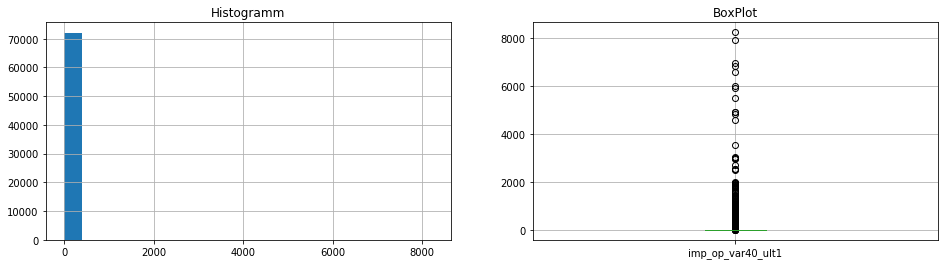

imp_op_var41_comer_ult1


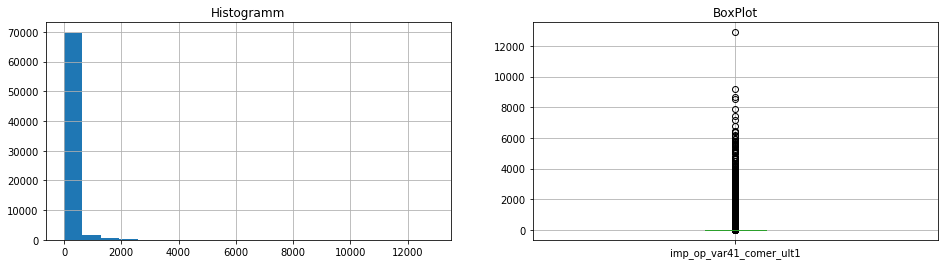

imp_op_var41_comer_ult3


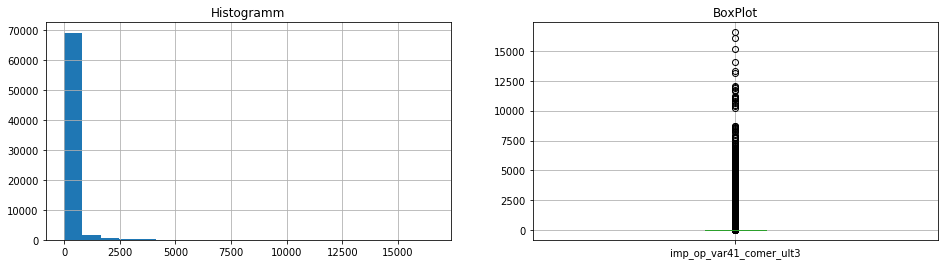

imp_op_var41_efect_ult1


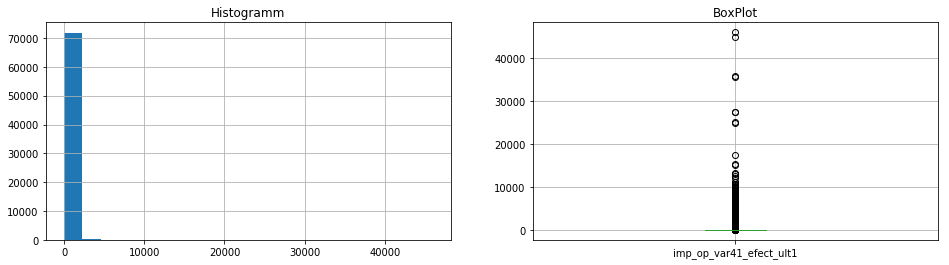

imp_op_var41_efect_ult3


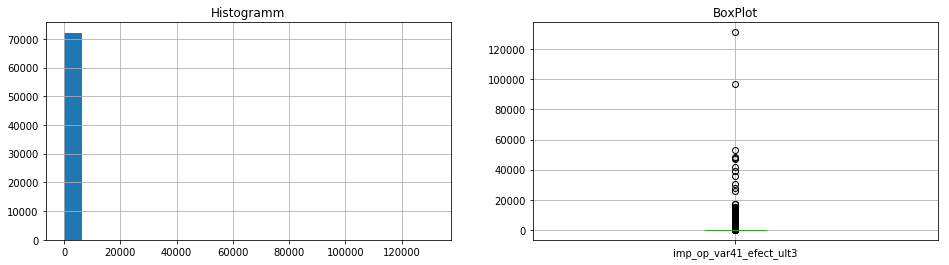

imp_op_var41_ult1


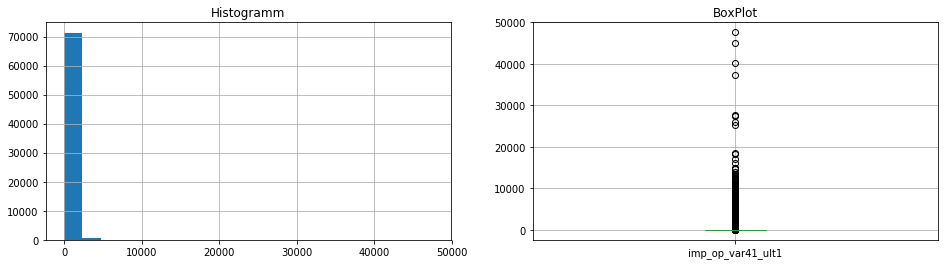

imp_op_var39_efect_ult1


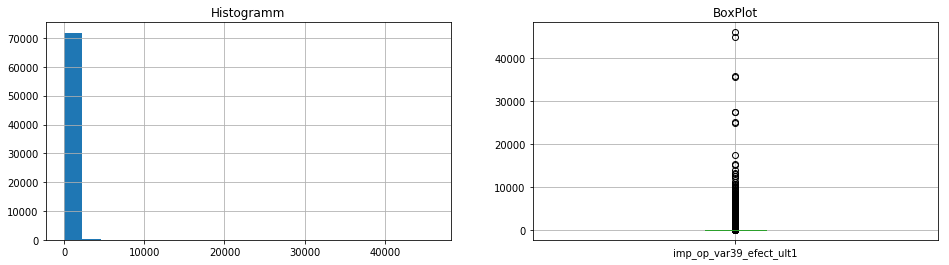

imp_op_var39_efect_ult3


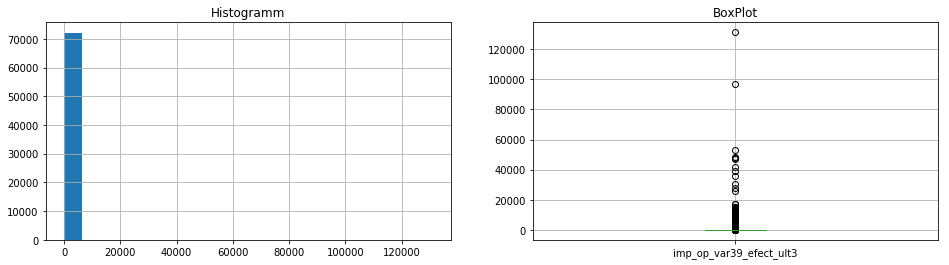

imp_op_var39_ult1


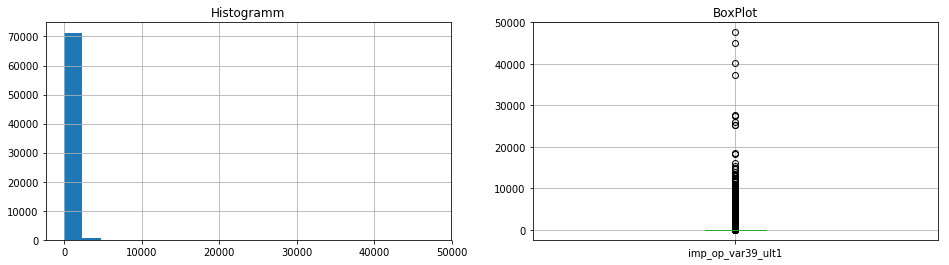

imp_sal_var16_ult1


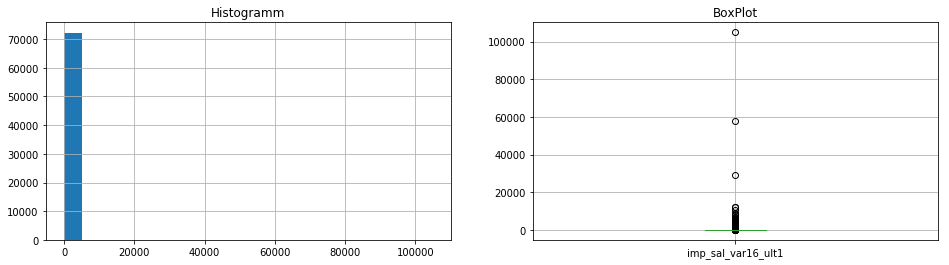

num_op_var41_hace2


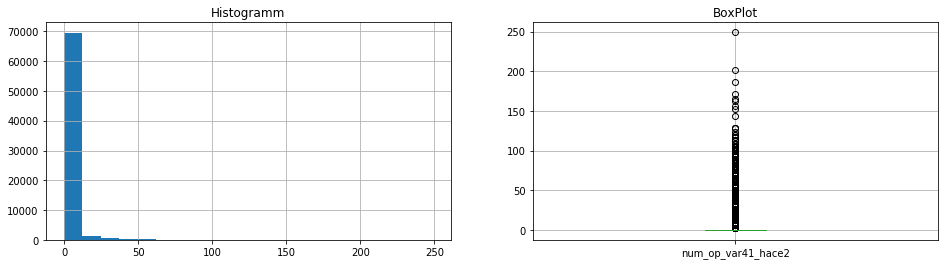

num_op_var41_ult1


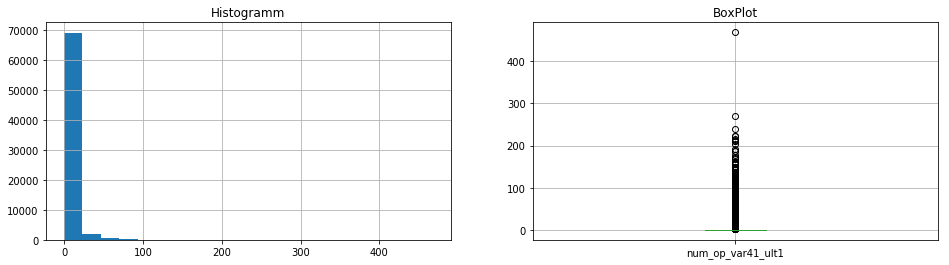

num_op_var41_ult3


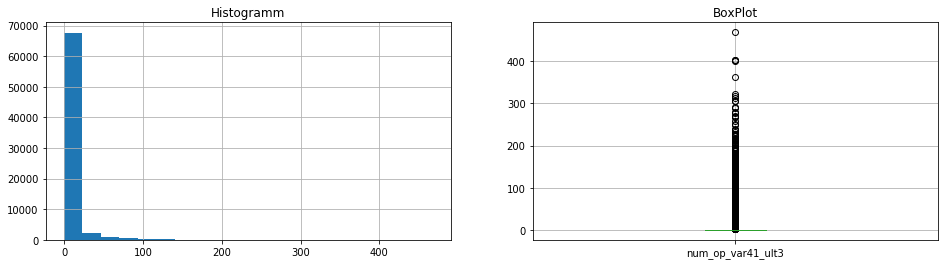

num_op_var39_hace2


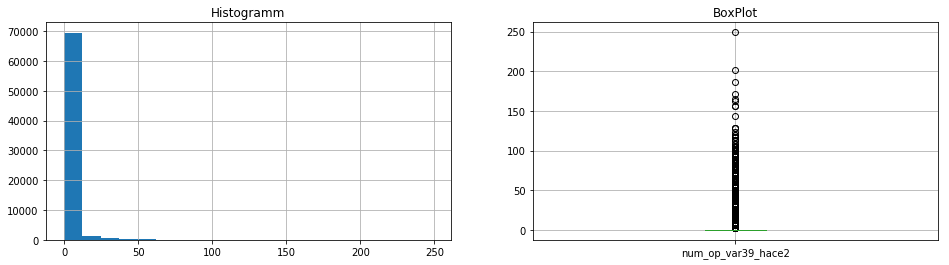

num_op_var39_ult1


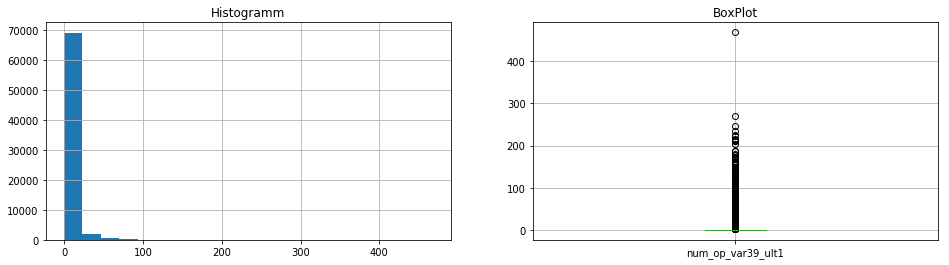

num_op_var39_ult3


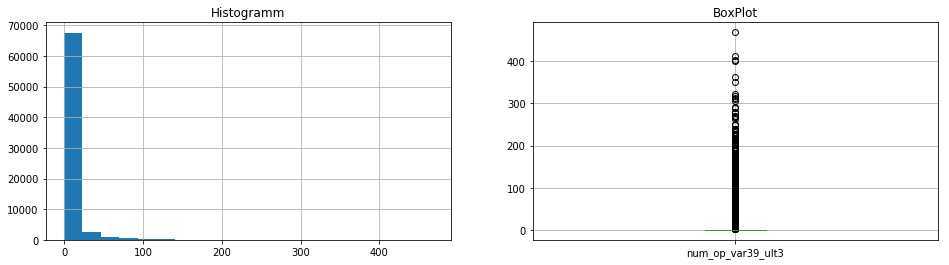

saldo_var1


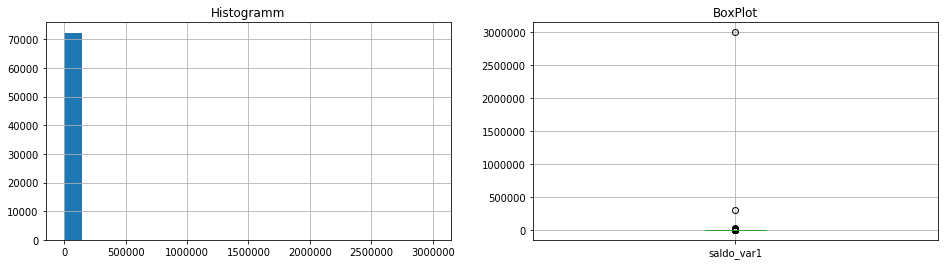

saldo_var5


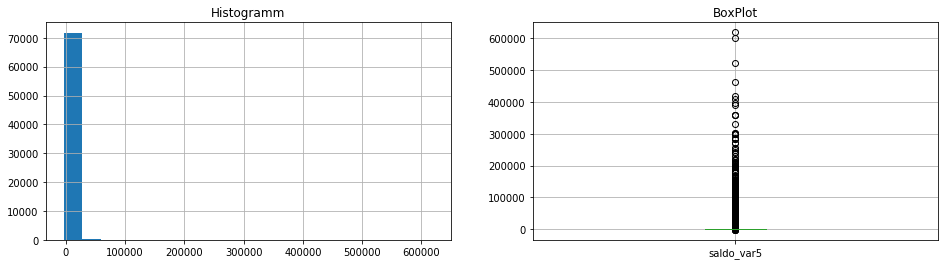

saldo_var8


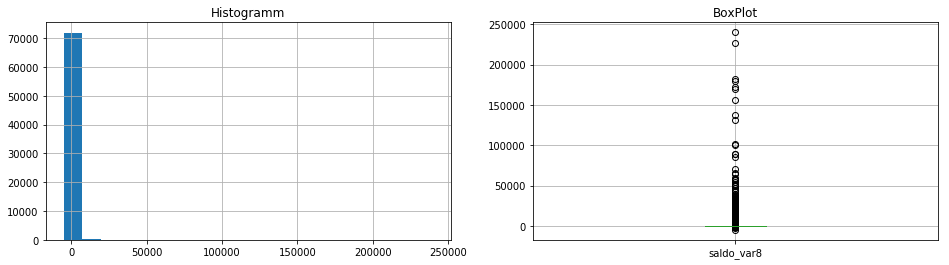

saldo_var12


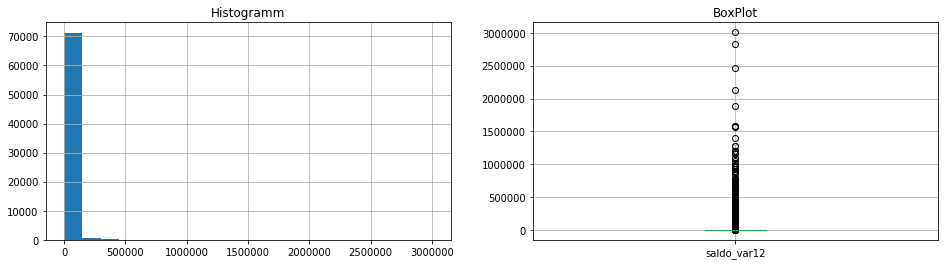

saldo_var13_corto


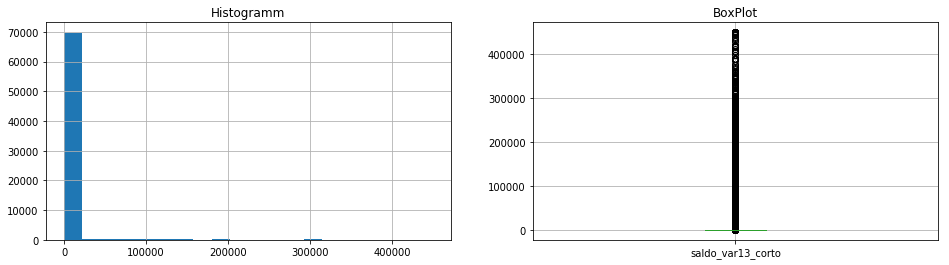

saldo_var13_largo


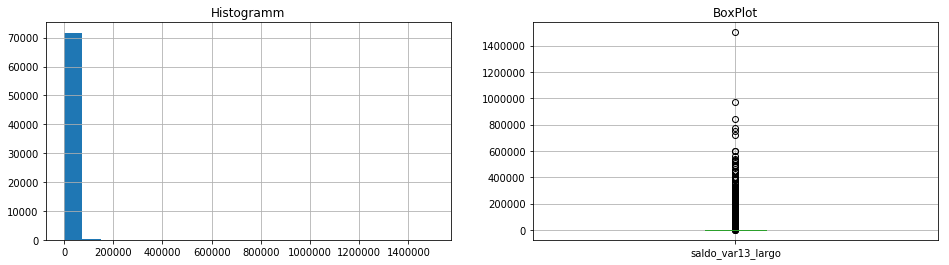

saldo_var13


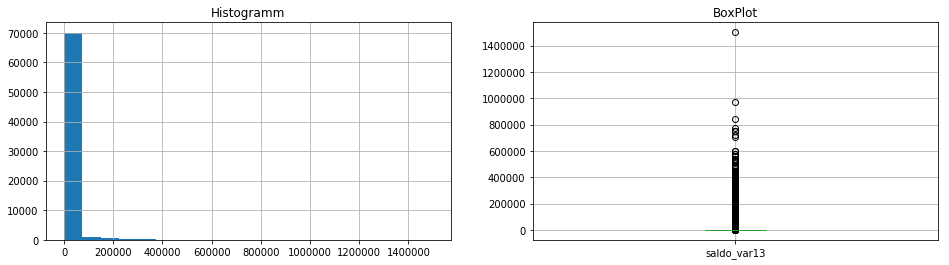

saldo_var14


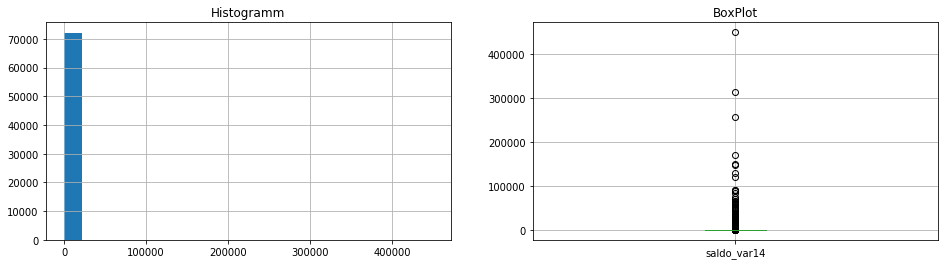

saldo_var17


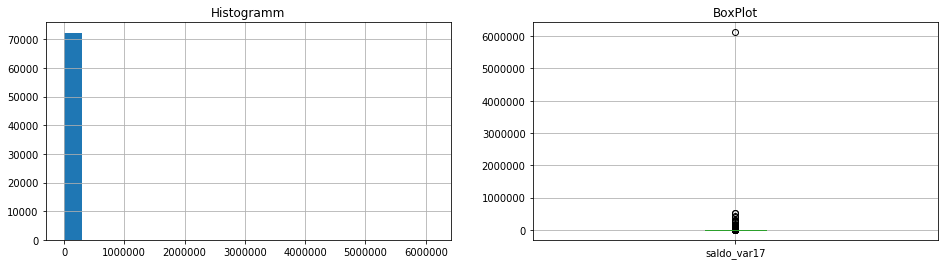

saldo_var20


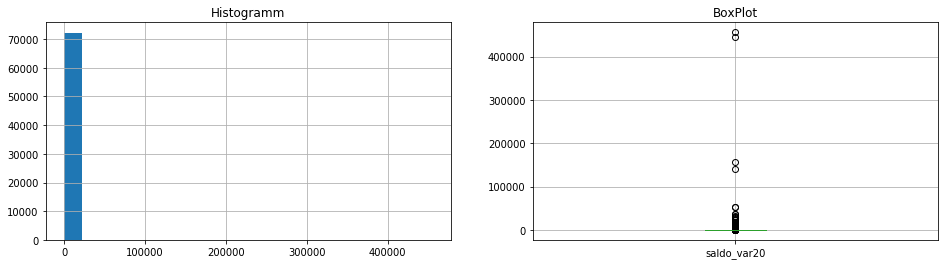

saldo_var24


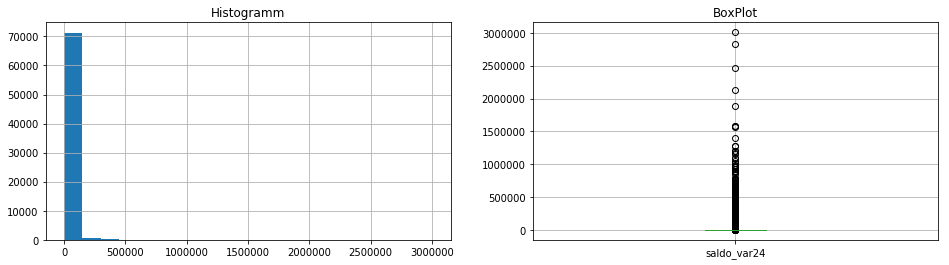

saldo_var26


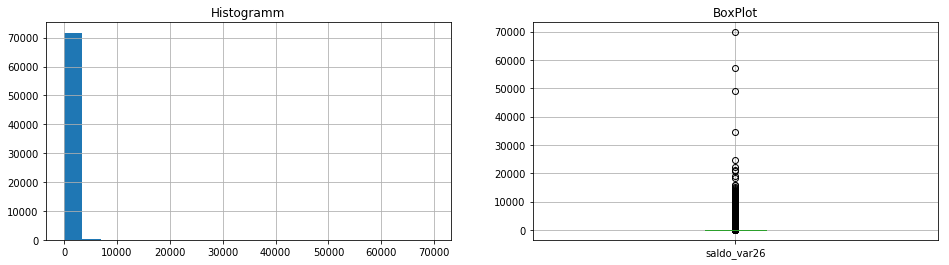

saldo_var25


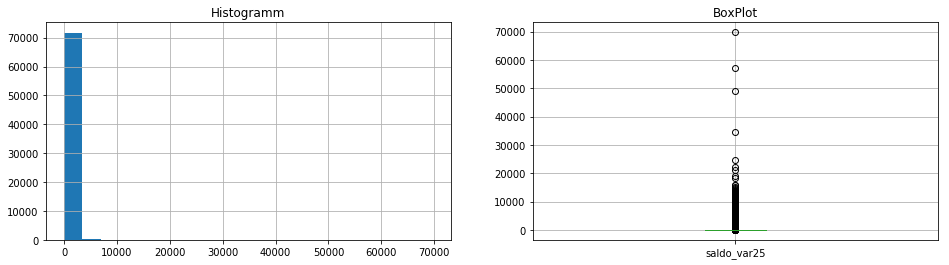

saldo_var30


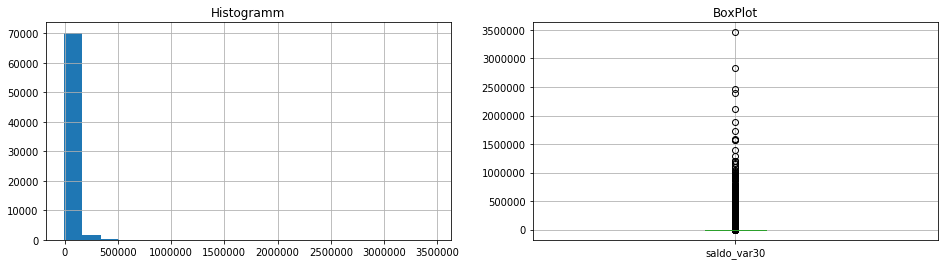

saldo_var31


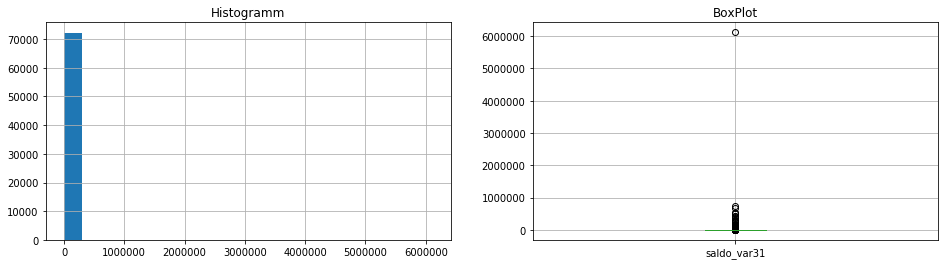

saldo_var32


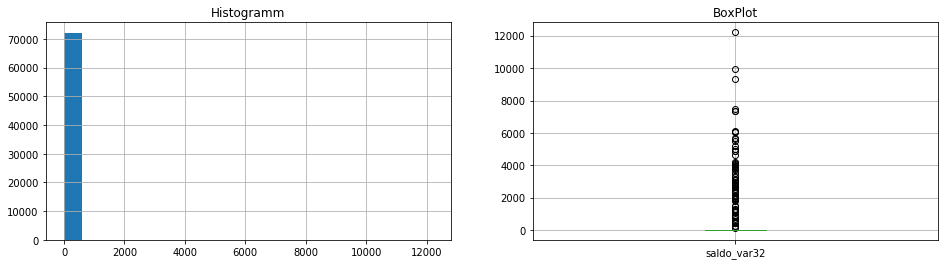

saldo_var37


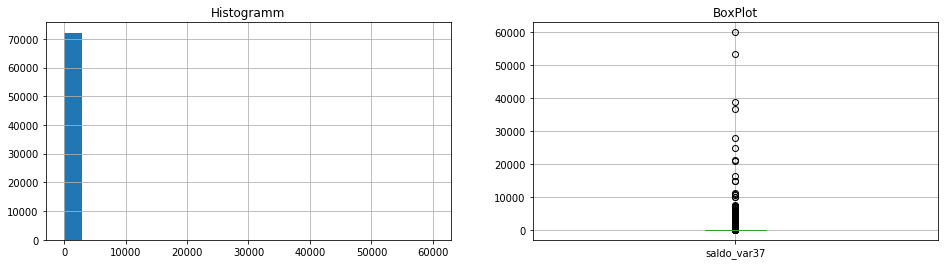

saldo_var40


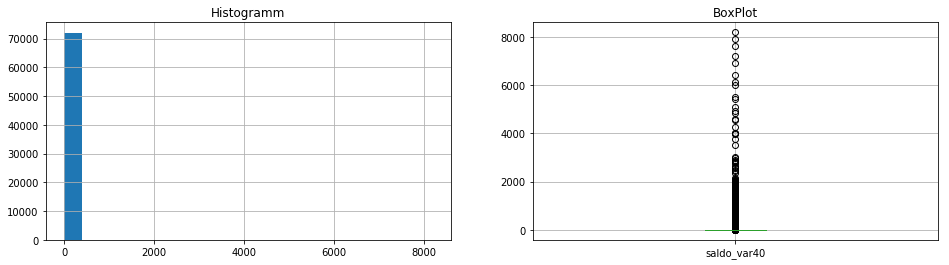

saldo_var42


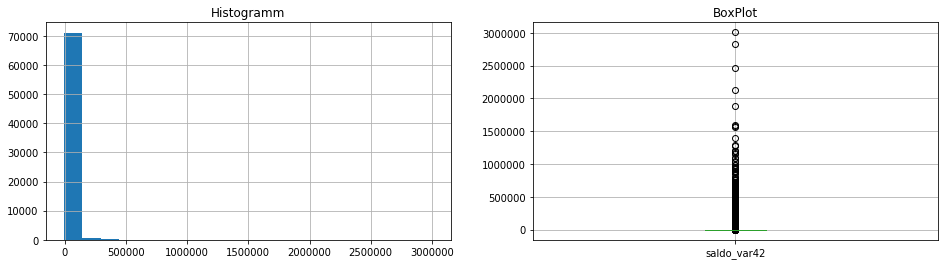

saldo_var44


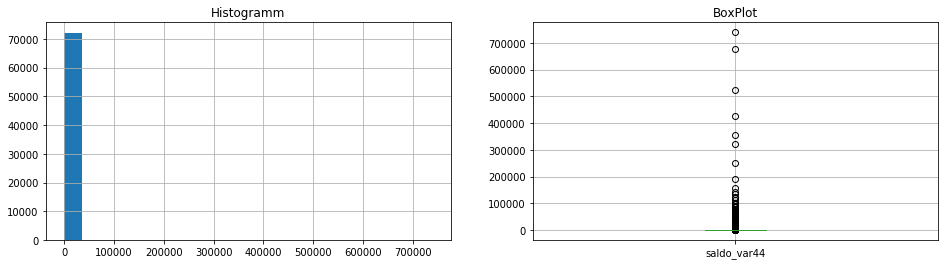

imp_aport_var13_hace3


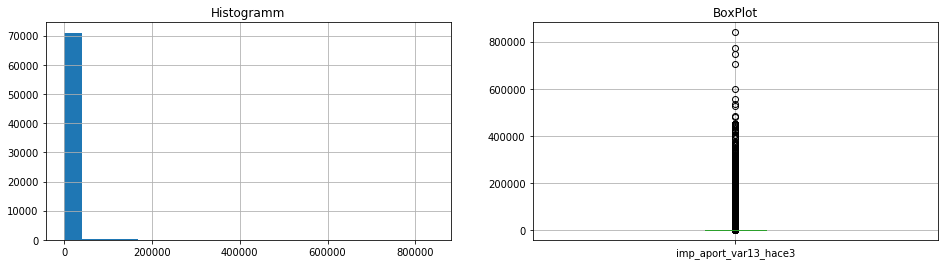

imp_aport_var13_ult1


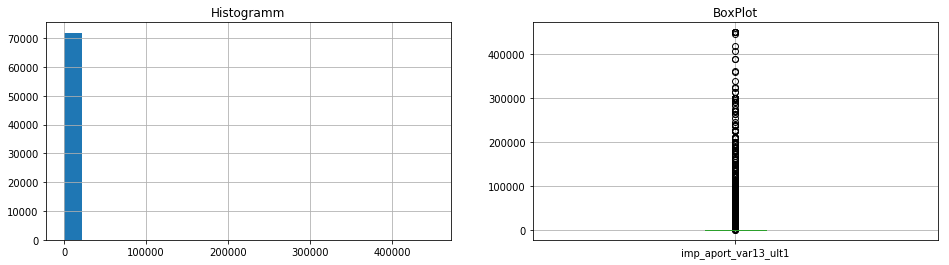

imp_var7_recib_ult1


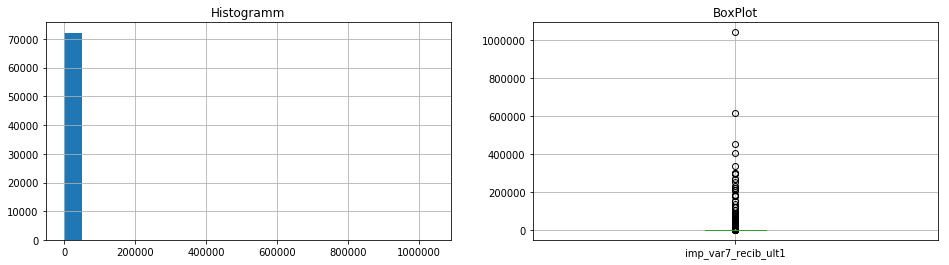

imp_compra_var44_ult1


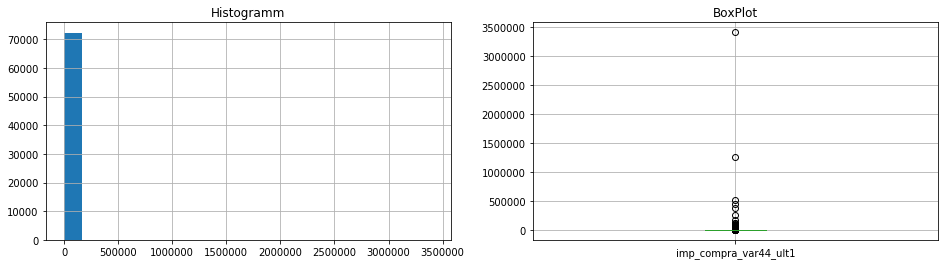

imp_var43_emit_ult1


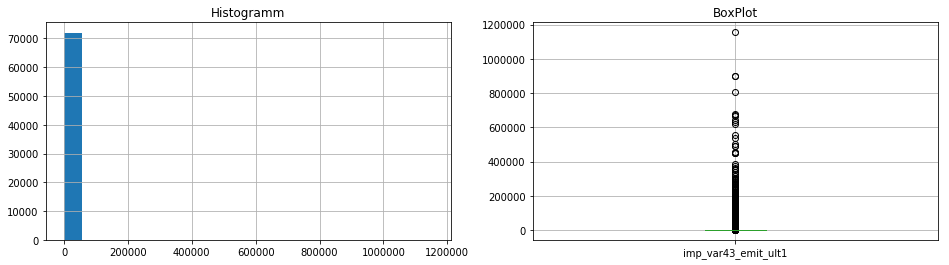

imp_trans_var37_ult1


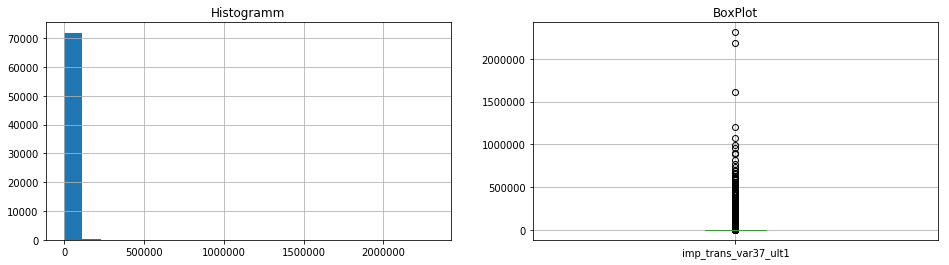

num_med_var45_ult3


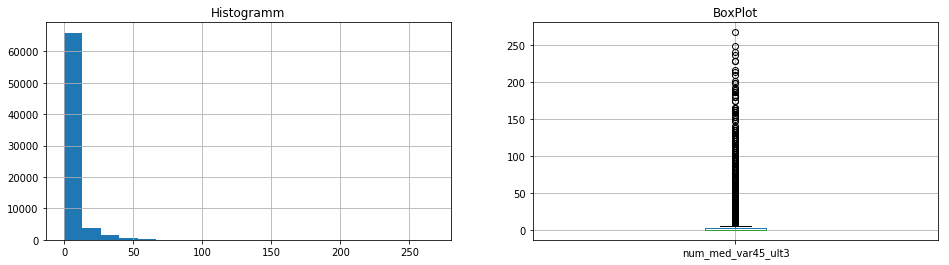

num_op_var39_comer_ult1


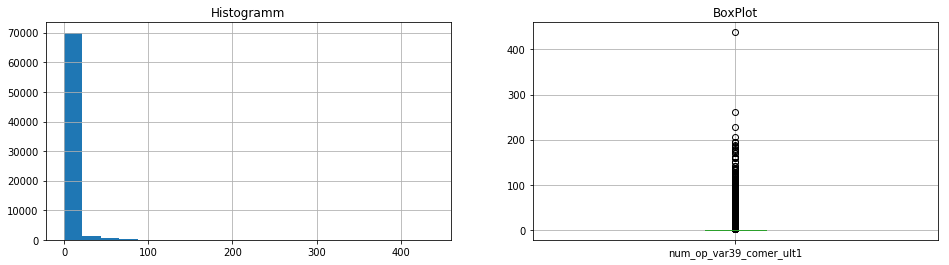

num_op_var39_comer_ult3


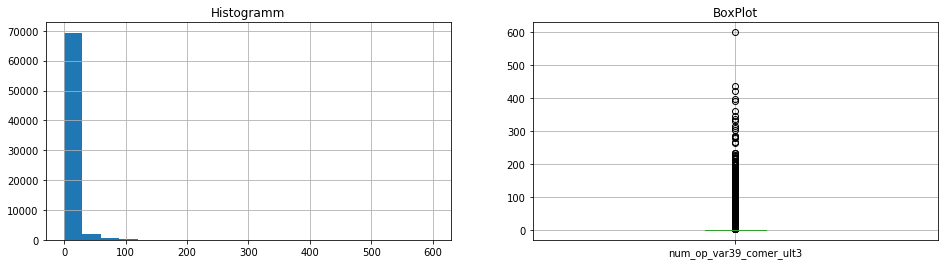

num_op_var41_comer_ult1


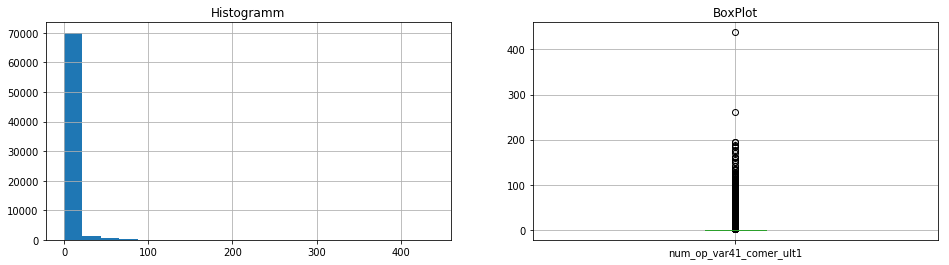

num_op_var41_comer_ult3


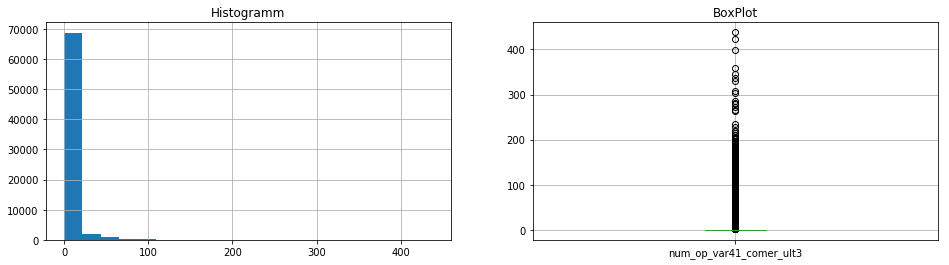

num_var45_hace2


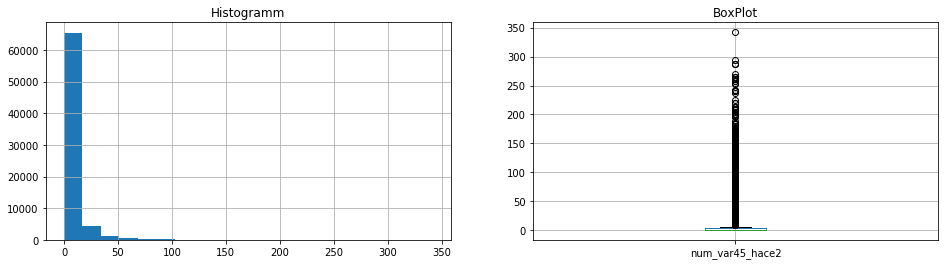

num_var45_hace3


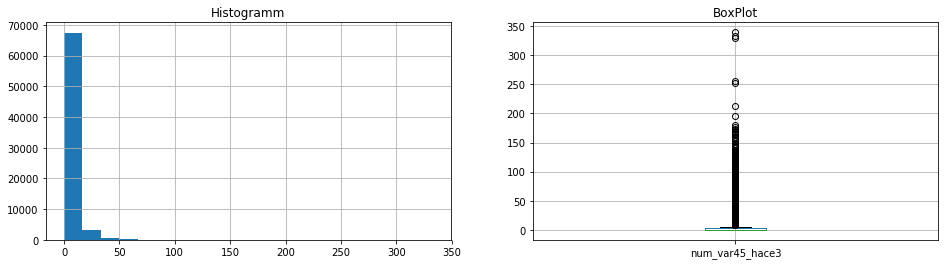

num_var45_ult1


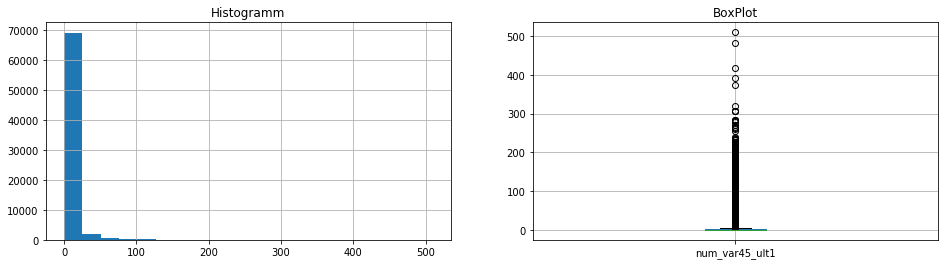

num_var45_ult3


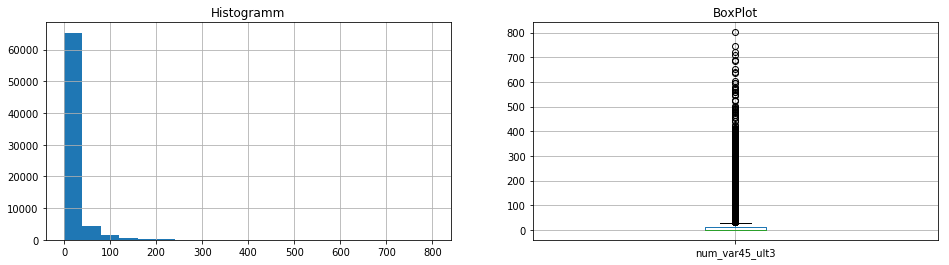

saldo_medio_var5_hace2


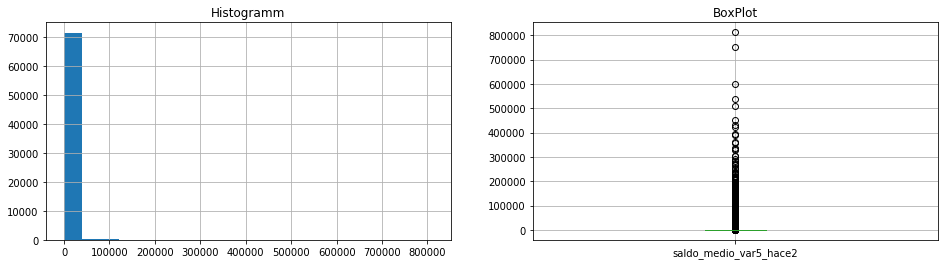

saldo_medio_var5_hace3


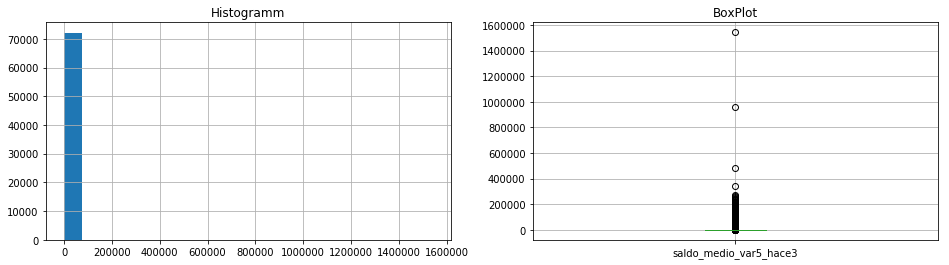

saldo_medio_var5_ult1


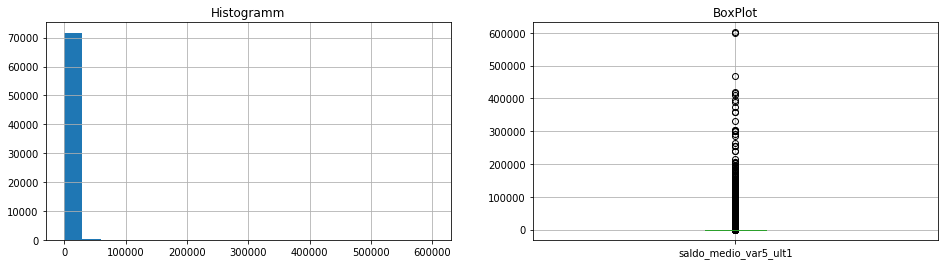

saldo_medio_var5_ult3


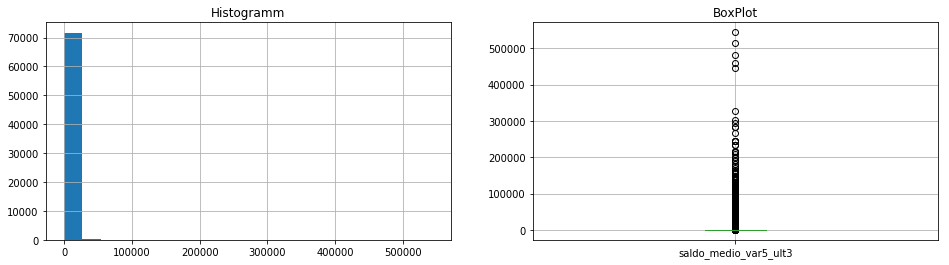

saldo_medio_var8_hace2


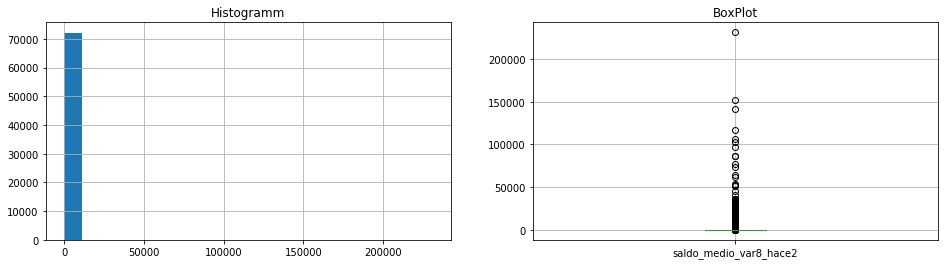

saldo_medio_var8_hace3


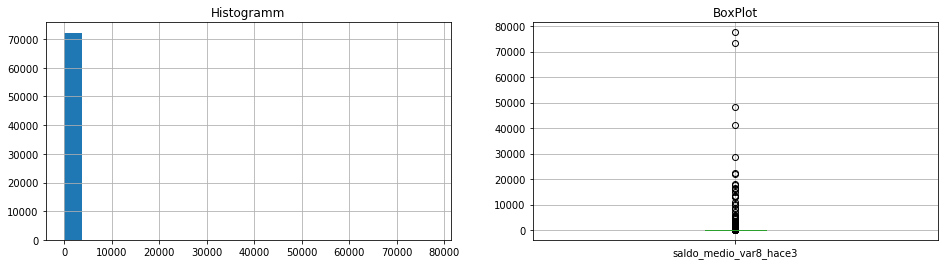

saldo_medio_var8_ult1


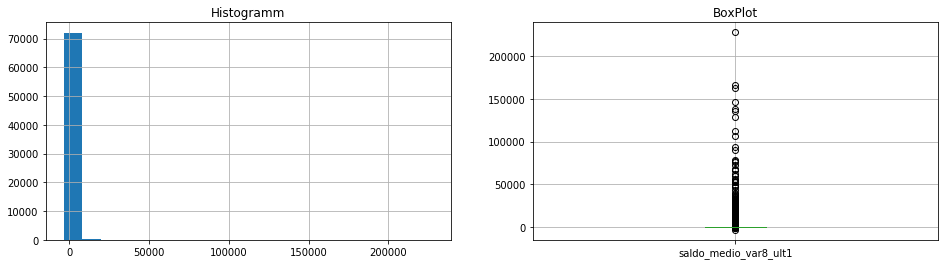

saldo_medio_var8_ult3


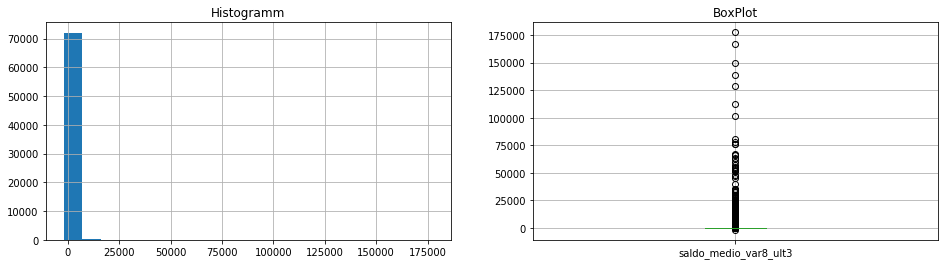

saldo_medio_var12_hace2


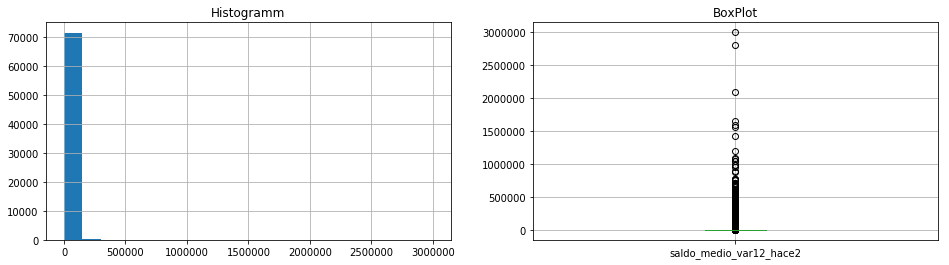

saldo_medio_var12_hace3


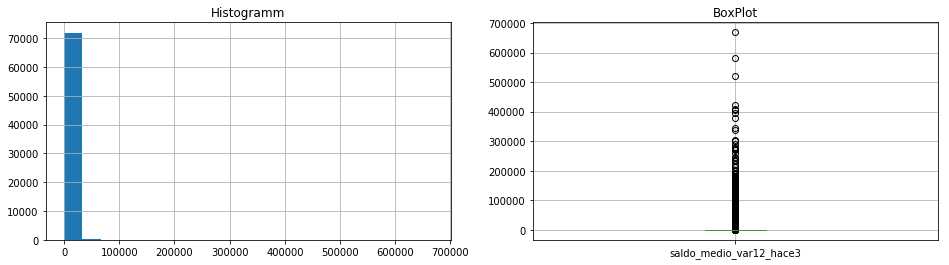

saldo_medio_var12_ult1


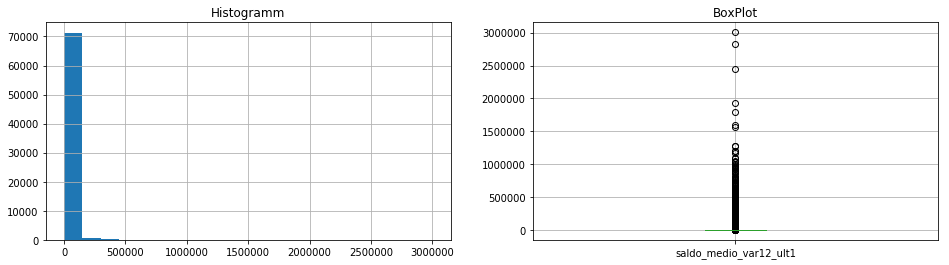

saldo_medio_var12_ult3


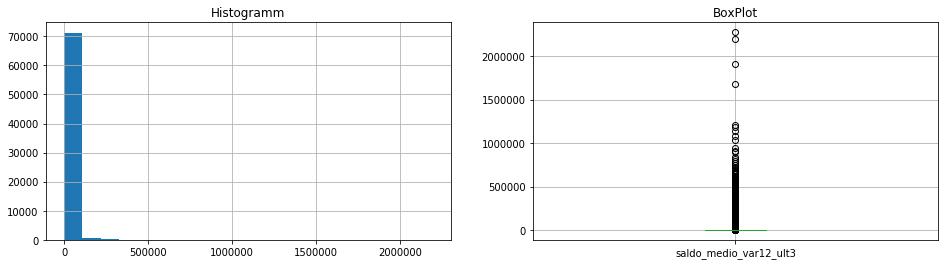

saldo_medio_var13_corto_hace2


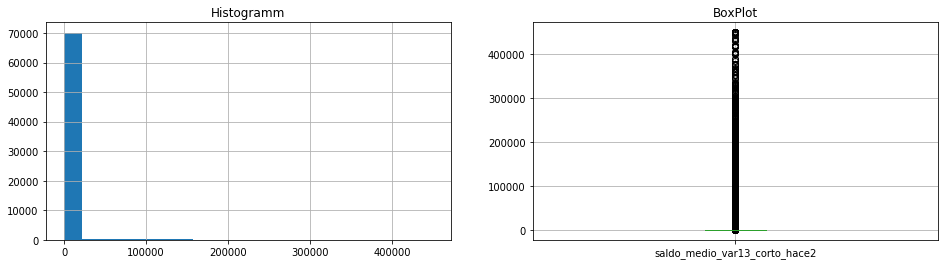

saldo_medio_var13_corto_hace3


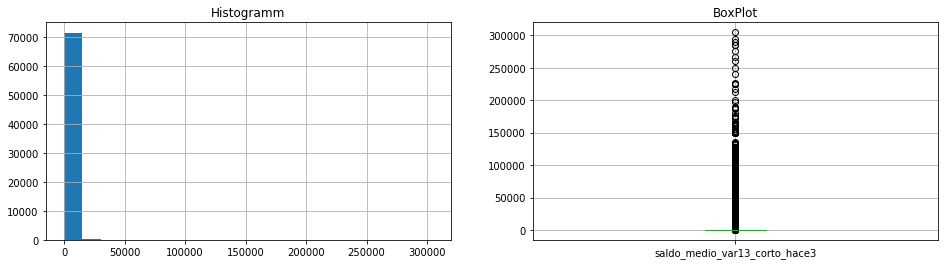

saldo_medio_var13_corto_ult1


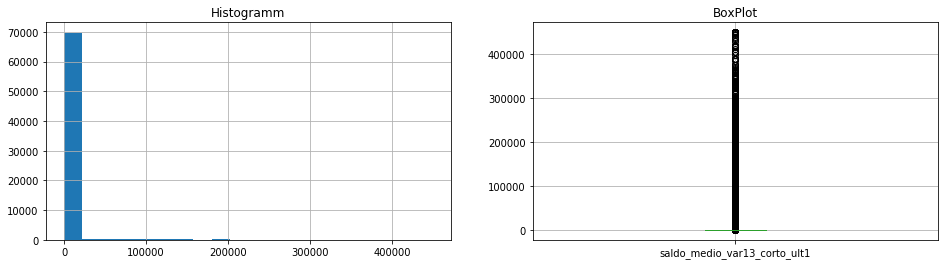

saldo_medio_var13_corto_ult3


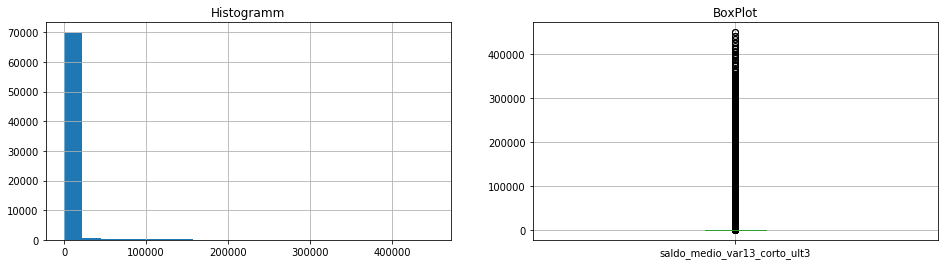

saldo_medio_var13_largo_hace2


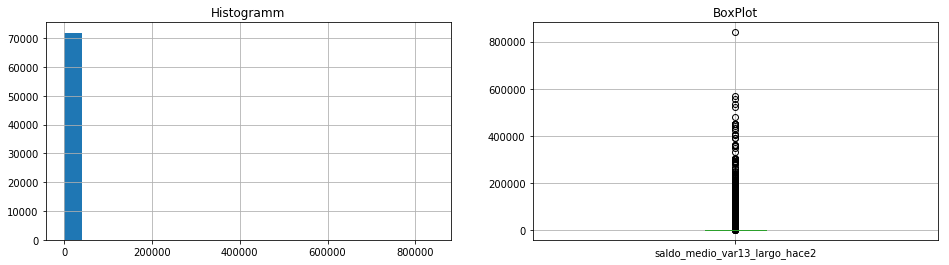

saldo_medio_var13_largo_hace3


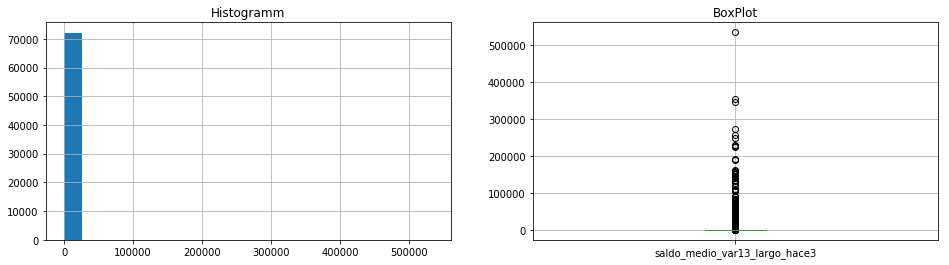

saldo_medio_var13_largo_ult1


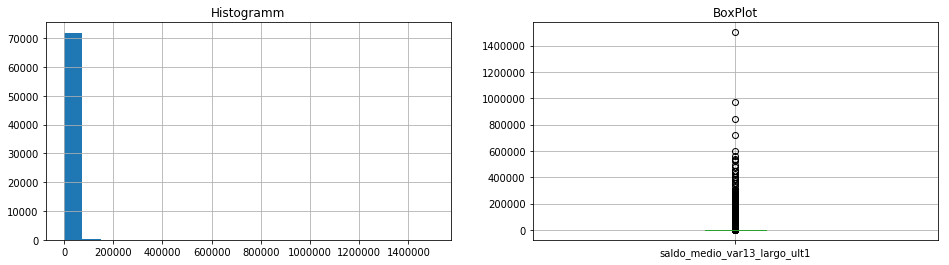

saldo_medio_var13_largo_ult3


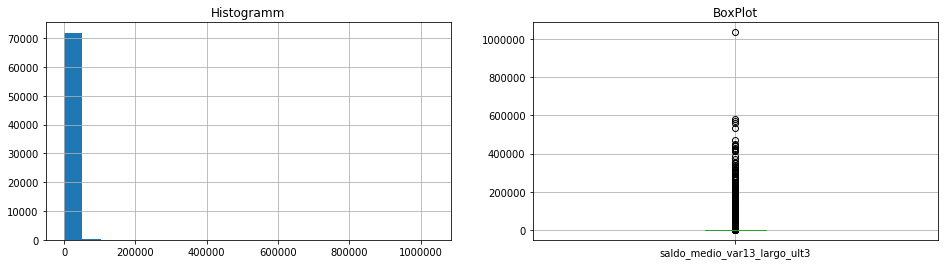

saldo_medio_var17_hace2


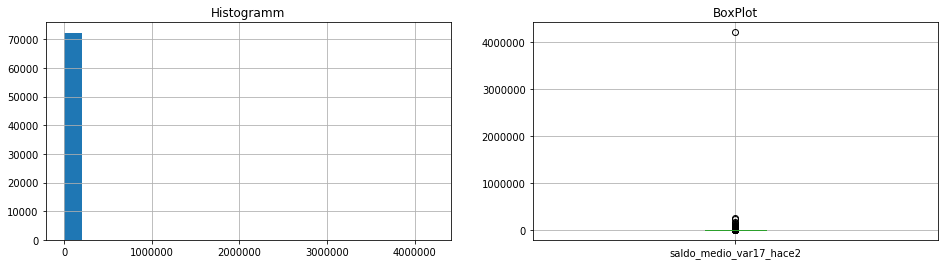

saldo_medio_var17_ult1


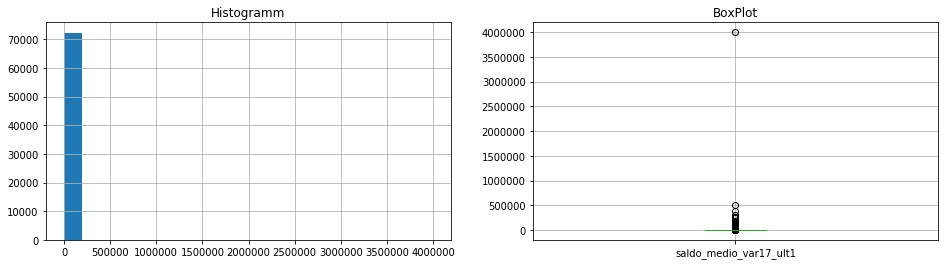

saldo_medio_var17_ult3


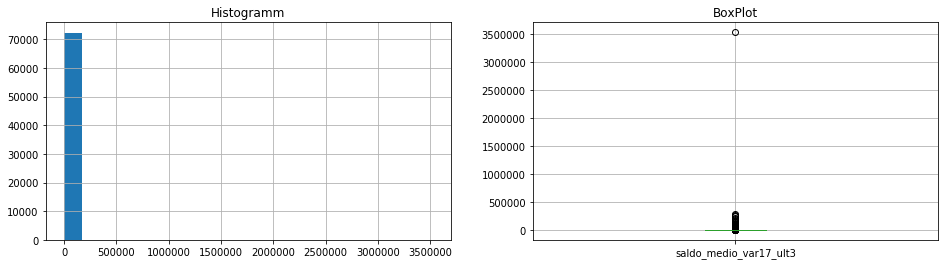

saldo_medio_var44_hace2


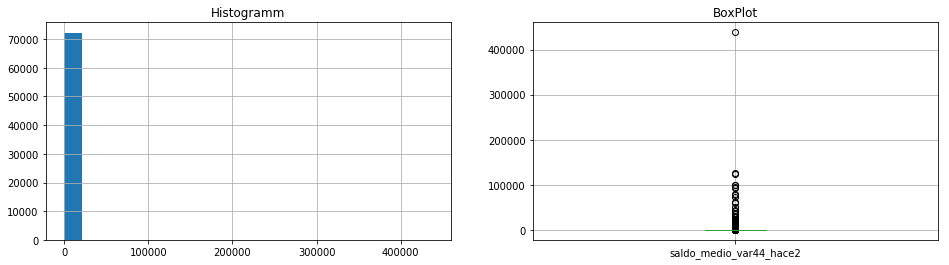

saldo_medio_var44_ult1


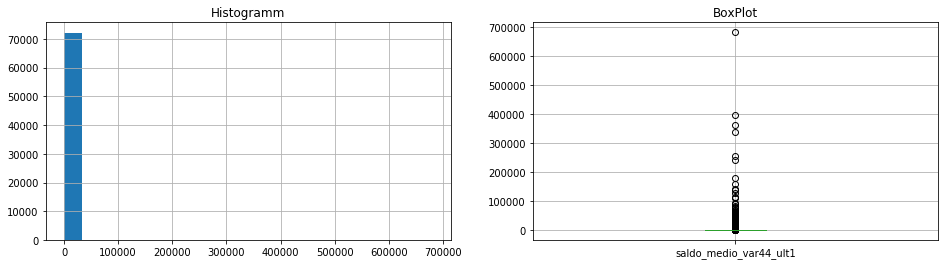

saldo_medio_var44_ult3


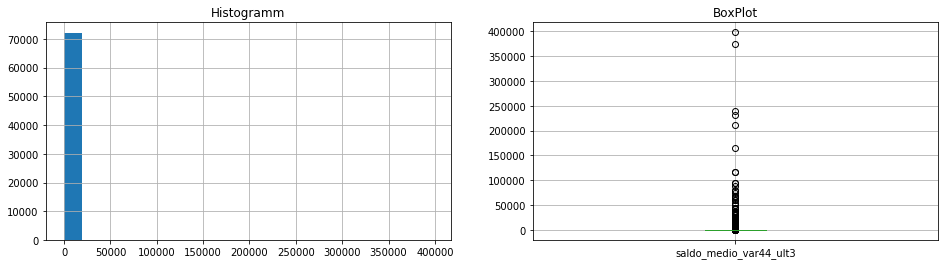

var38


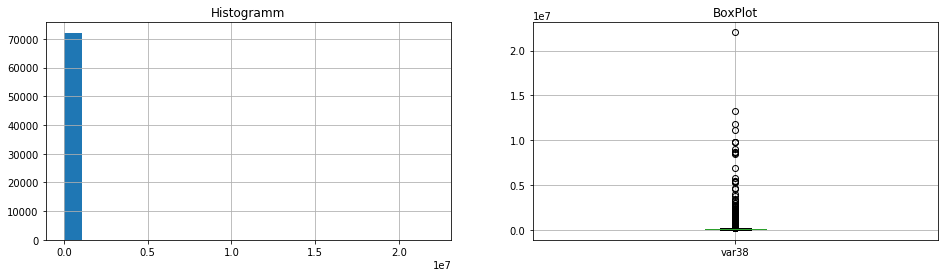

In [42]:
# Check the distribution of the continuous variables
for var in X_train[continuous]:
    if var != 'ID':
        #define figure size
        plt.figure(figsize=(16, 4))

        # histogram
        print(str(var))
        plt.subplot(1, 2, 1)
        fig = X_train[var].hist(bins=20)
        plt.title('Histogramm')

        # boxplot
        plt.subplot(1, 2, 2)
        fig = df.boxplot(column=var)
        plt.title('BoxPlot')

        plt.show()

-> Many of the continuous features seem to have highly concentrated values

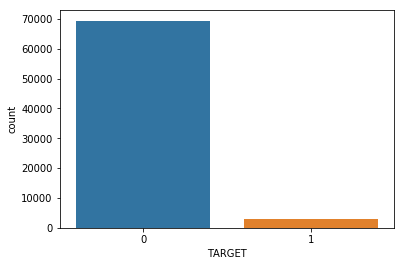

In [55]:
#Exploring the balance of the Target variable
sns.countplot(y_train)

    -> The Target variable is highly unbalanced. This fact need to be taken into consideration when building a model

# Feature Selection

## Dealing with Duplicates

In [43]:
#Check for dupplicates
X_trans = X_train.T
print('Amount of dupplicated feautures: {}'.format(X_trans.duplicated().sum()))

Amount of dupplicated feautures: 62


In [44]:
dupplicated_features = X_trans[X_trans.duplicated()].index

In [45]:
#Dropping dupplicated features
X_train.drop(columns=dupplicated_features, inplace=True)
X_test.drop(columns=dupplicated_features, inplace=True)
X_dev.drop(columns=dupplicated_features, inplace=True)
X_test.shape, X_train.shape, X_dev.shape

((75818, 308), (72219, 307), (3801, 307))

## Dealing with quasi-constants

In [46]:
# First, lets check for and drop constant features
constant_features = [var for var in X_train.columns if X_train[var].std() == 0]
constant_features

['ind_var2_0']

In [47]:
X_train.drop(columns=constant_features, inplace=True)
X_test.drop(columns=constant_features, inplace=True)
X_dev.drop(columns=constant_features, inplace=True)
X_test.shape, X_train.shape, X_dev.shape

((75818, 307), (72219, 306), (3801, 306))

In [48]:
# Removing quasi constant features (where 97% of the entries have the same value):
quasi_constants = []
for var in X_train.columns:
    tem = X_train[var].value_counts()/X_train.shape[0]
    if tem.iloc[0] >= 0.97:
        quasi_constants.append(var)
len(quasi_constants)

198

In [49]:
X_train.drop(columns=quasi_constants, inplace=True)
X_test.drop(columns=quasi_constants, inplace=True)
X_dev.drop(columns=quasi_constants, inplace=True)
X_test.shape, X_train.shape, X_dev.shape

((75818, 109), (72219, 108), (3801, 108))

## Removing correlated features

In [50]:
# Saving the datasets in the current state, in case we wont to use that
X_dev_nc = X_dev.copy()
X_test_nc = X_test.copy()
X_train_nc = X_train.copy()

In [19]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.90)
print('correlated features: ', len(set(corr_features)) )
print(corr_features)

correlated features:  51
{'num_var13', 'num_var45_ult3', 'num_op_var39_hace2', 'num_var13_0', 'num_var45_hace2', 'imp_op_var39_efect_ult1', 'imp_op_var41_comer_ult1', 'ind_var10cte_ult1', 'num_meses_var13_corto_ult3', 'num_op_var41_comer_ult3', 'num_op_var39_ult1', 'num_var5_0', 'ind_var9_ult1', 'num_var42_0', 'saldo_var24', 'ind_var24', 'num_var41_0', 'num_var13_corto', 'ind_var13_corto_0', 'num_var35', 'num_op_var39_efect_ult1', 'saldo_medio_var12_ult3', 'imp_op_var41_comer_ult3', 'ind_var41_0', 'saldo_var42', 'imp_op_var39_ult1', 'num_op_var41_ult3', 'num_op_var39_ult3', 'saldo_medio_var13_corto_ult3', 'ind_var13', 'num_var24', 'ind_var9_cte_ult1', 'num_op_var39_comer_ult3', 'ind_var37_0', 'num_op_var41_efect_ult3', 'num_meses_var12_ult3', 'num_var8_0', 'num_op_var41_comer_ult1', 'num_med_var22_ult3', 'num_var12', 'saldo_medio_var12_ult1', 'num_meses_var5_ult3', 'num_var24_0', 'saldo_medio_var13_corto_ult1', 'imp_op_var39_efect_ult3', 'num_op_var39_comer_ult1', 'num_var13_corto_0', 

In [20]:
X_train.drop(columns=corr_features, inplace=True)
X_test.drop(columns=corr_features, inplace=True)
X_dev.drop(columns=corr_features, inplace=True)
X_test.shape, X_train.shape, X_dev.shape

((75818, 58), (72219, 58), (3801, 58))

In [ ]:
# Saving the datasets in the current state, in case we wont to use that
X_dev_corr = X_dev.copy()
X_test_corr = X_test.copy()
X_train_corr = X_train.copy()

## Recursive Features Selection
based on Gradient Boosting Classification

In [51]:
from sklearn.feature_selection import RFE 
from sklearn.ensemble import GradientBoostingClassifier

### Selecting Recursively

In [52]:
sel_ = RFE(GradientBoostingClassifier(), n_features_to_select=30)
sel_.fit(X_train, y_train)

RFE(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                         learning_rate=0.1, loss='deviance',
                                         max_depth=3, max_features=None,
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=100,
                                         n_iter_no_change=None, presort='auto',
                                         random_state=None, subsample=1.0,
                                         tol=0.0001, validation_fraction=0.1,
                                         verbose=0, warm_start=False),
    n_features_to_s

In [57]:
selected = X_train.columns[(sel_.get_support())]
len(selected)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 30 but corresponding boolean dimension is 108

In [54]:
selected

Index(['var15', 'imp_ent_var16_ult1', 'imp_op_var41_comer_ult1',
       'imp_op_var41_efect_ult1', 'imp_op_var41_efect_ult3',
       'imp_op_var39_efect_ult1', 'imp_op_var39_ult1', 'num_var4',
       'num_var8_0', 'num_op_var41_hace2', 'num_op_var41_ult3', 'num_var30_0',
       'num_var41_0', 'num_var42_0', 'saldo_var5', 'saldo_var30',
       'saldo_var42', 'num_var22_hace2', 'num_var22_ult1', 'num_var22_ult3',
       'num_meses_var5_ult3', 'num_op_var39_efect_ult1', 'num_var45_hace2',
       'num_var45_hace3', 'num_var45_ult1', 'saldo_medio_var5_hace2',
       'saldo_medio_var5_hace3', 'saldo_medio_var5_ult1',
       'saldo_medio_var5_ult3', 'var38'],
      dtype='object')

In [56]:
X_train = X_train[selected]
X_test = X_test[selected]
X_dev = X_dev[selected]
X_test.shape, X_train.shape, X_dev.shape

((75818, 30), (72219, 30), (3801, 30))

In [59]:
X_train.head()

,var15,imp_ent_var16_ult1,imp_op_var41_comer_ult1,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var39_efect_ult1,imp_op_var39_ult1,num_var4,num_var8_0,num_op_var41_hace2,num_op_var41_ult3,num_var30_0,num_var41_0,num_var42_0,saldo_var5,saldo_var30,saldo_var42,num_var22_hace2,num_var22_ult1,num_var22_ult3,num_meses_var5_ult3,num_op_var39_efect_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,var38
16391,25,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,3,3,3,90.00,90.00,90.00,0,0,0,3,0,0,0,0,90.00,75.45,90.0,85.14,117310.979016
71000,23,0.0,0.0,0.0,60.0,0.0,0.0,2,0,6,6,3,3,3,9.30,9.30,9.30,6,0,6,3,0,3,0,0,30.48,77.58,9.3,39.12,60597.000000
45079,30,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0,0,3,3,3,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0.00,0.0,0.00,51661.770000
36844,61,1200.0,444.0,0.0,2100.0,0.0,444.0,3,0,15,27,3,3,3,2677.86,2677.86,2677.86,0,0,0,3,0,12,27,51,1086.75,1186.11,1539.3,1270.71,137458.080000
57859,25,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,3,0,3,3.00,3.00,3.00,0,0,0,3,0,0,0,0,3.00,2.22,3.0,2.73,30088.440000


# Building a model

In [60]:
# Importing evaluation metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## XGBoost

In [61]:
# Import for XGBOOST
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

In [62]:
# Calculation of a value for the imbalance ratio (number of positives over the number of negatives)
tmp = y_train.value_counts()
ratio = tmp[0]/tmp[1]
ratio 

24.411330049261085

In [63]:
# Creating an instance of the XGBClassifier
clf_gs = xgb.XGBClassifier(
                learning_rate=0.01,
#                 subsample=1.0,
                colsample_bytree=0.5,
                scale_pos_weight = ratio,
#                 reg_alpha=0.03,
                seed=1301,
                n_jobs=-1,
                )

In [64]:
# Checking typical values for the most important parameters to tune
params_xgb_gs = {
    'max_depth': [5, 15, 30],
    'n_estimators': [500, 1000],
    'subsample': [0.5, 1],
    'min_child_weight': [0.5, 1, 3]
}

In [ ]:
grid_search_xgb = GridSearchCV(clf_gs, param_grid=params_xgb_gs, cv=3, scoring='roc_auc')
xgbm_model = grid_search_xgb.fit(X_train, y_train)

In [ ]:
xgbm_model.best_params_

In [ ]:
# The best parameters are:

# {'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.5}

In [67]:
clf_gs = xgb.XGBClassifier(
            learning_rate=0.01,
            subsample=0.5,
            max_depth=5,
            min_child_weight=3,
            n_estimators=500,
            colsample_bytree=0.5,
            scale_pos_weight = ratio,
            seed=1301,
            n_jobs=-1
            )

In [68]:
clf_gs.fit(X_train, y_train, early_stopping_rounds=50, eval_metric=["auc"],
        eval_set=[(X_train, y_train), (X_dev, y_dev)])

[0]	validation_0-auc:0.825303	validation_1-auc:0.855093
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.829229	validation_1-auc:0.851679
[2]	validation_0-auc:0.834844	validation_1-auc:0.853521
[3]	validation_0-auc:0.837165	validation_1-auc:0.8557
[4]	validation_0-auc:0.837453	validation_1-auc:0.856022
[5]	validation_0-auc:0.83393	validation_1-auc:0.855131
[6]	validation_0-auc:0.832084	validation_1-auc:0.855843
[7]	validation_0-auc:0.829741	validation_1-auc:0.855447
[8]	validation_0-auc:0.828866	validation_1-auc:0.852273
[9]	validation_0-auc:0.832385	validation_1-auc:0.855007
[10]	validation_0-auc:0.835874	validation_1-auc:0.857212
[11]	validation_0-auc:0.83415	validation_1-auc:0.858493
[12]	validation_0-auc:0.832552	validation_1-auc:0.858323
[13]	validation_0-auc:0.834638	validation_1-auc:0.860524
[14]	validation_0-auc:0.833555	validation_1-auc:0.859211
[1

[142]	validation_0-auc:0.852691	validation_1-auc:0.8672
[143]	validation_0-auc:0.85288	validation_1-auc:0.867566
[144]	validation_0-auc:0.853006	validation_1-auc:0.867735
[145]	validation_0-auc:0.853004	validation_1-auc:0.867797
[146]	validation_0-auc:0.853032	validation_1-auc:0.86796
[147]	validation_0-auc:0.853005	validation_1-auc:0.867819
[148]	validation_0-auc:0.853222	validation_1-auc:0.868066
[149]	validation_0-auc:0.853263	validation_1-auc:0.868062
[150]	validation_0-auc:0.853373	validation_1-auc:0.868259
[151]	validation_0-auc:0.853412	validation_1-auc:0.868164
[152]	validation_0-auc:0.853539	validation_1-auc:0.868345
[153]	validation_0-auc:0.853528	validation_1-auc:0.868204
[154]	validation_0-auc:0.853514	validation_1-auc:0.868124
[155]	validation_0-auc:0.85355	validation_1-auc:0.868062
[156]	validation_0-auc:0.853541	validation_1-auc:0.868076
[157]	validation_0-auc:0.853653	validation_1-auc:0.868073
[158]	validation_0-auc:0.853848	validation_1-auc:0.868181
[159]	validation_0-

[284]	validation_0-auc:0.862198	validation_1-auc:0.870209
[285]	validation_0-auc:0.862263	validation_1-auc:0.870117
[286]	validation_0-auc:0.862319	validation_1-auc:0.870073
[287]	validation_0-auc:0.862384	validation_1-auc:0.870138
[288]	validation_0-auc:0.862408	validation_1-auc:0.870155
[289]	validation_0-auc:0.862446	validation_1-auc:0.87016
[290]	validation_0-auc:0.862476	validation_1-auc:0.870181
[291]	validation_0-auc:0.862504	validation_1-auc:0.870203
[292]	validation_0-auc:0.86257	validation_1-auc:0.87012
[293]	validation_0-auc:0.862627	validation_1-auc:0.870126
[294]	validation_0-auc:0.862671	validation_1-auc:0.870152
[295]	validation_0-auc:0.862712	validation_1-auc:0.870054
Stopping. Best iteration:
[245]	validation_0-auc:0.860256	validation_1-auc:0.870851



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=24.411330049261085,
              seed=1301, silent=None, subsample=0.5, verbosity=1)

In [71]:
# Making Predictions for the Train Set and the Dev Set
y_dev_pred = clf_gs.predict(X_dev)
y_train_pred = clf_gs.predict(X_train)

y_dev_proba = clf_gs.predict_proba(X_dev)
y_train_proba = clf_gs.predict_proba(X_train)

In [79]:
#Printing Results
print('Train Set auc: {}'.format(roc_auc_score(y_train, y_train_proba[:,1])))
print('Train Set accuracy: {}'.format(accuracy_score(y_train, y_train_pred)))
print()
print('Dev Set auc: {}'.format(roc_auc_score(y_dev, y_dev_proba[:,1])))
print('Dev Set accuracy: {}'.format(accuracy_score(y_dev, y_dev_pred)))
print('')
print('Dev Set Confusion matrix:')
print(confusion_matrix(y_dev, y_dev_pred))

Train Set auc: 0.8602557128606456
Train Set accuracy: 0.7904706517675404

Dev Set auc: 0.8708506653850616
Dev Set accuracy: 0.8050513022888713

Dev Set Confusion matrix:
[[2930  705]
 [  36  130]]


    Submission for the competition

In [96]:
predictions_X_test = clf_gs.predict_proba(X_test)
test_id = pd.read_csv('test.csv').iloc[:,0]
submission = pd.DataFrame({"ID":test_id, "TARGET": predictions_X_test[:,1]})
submission.to_csv("submission_v8.csv", index=False)

## LightGBM

In [87]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [88]:
# Calculation of a value for the imbalance ratio (number of positives over the number of negatives)
tmp = y_train.value_counts()
ratio = tmp[0]/tmp[1]
ratio

24.411330049261085

In [89]:
# Parameters for Gridsearch
param_gs = {'num_leaves': [20, 50, 100], 
         'objective': ['binary'],
         'max_depth': [10, 20, 30],
         'learning_rate': [.05, 0.1],
         'max_bin': [100],
         'scale_pos_weight': [ratio],
        }
param_gs['metric'] = ['auc'
#                    , 'binary_logloss'
                  ]

In [90]:
#GRIDSEARCH
lgb_classifier = lgb.LGBMClassifier(metric='auc')
grid_search2 = GridSearchCV(lgb_classifier, param_grid=param_gs, cv=5, scoring='roc_auc')
lgbm_model = grid_search2.fit(X_train, y_train)

In [91]:
# Making Predictions for the Train Set and the Dev Set
y_dev_pred_lgb = lgbm_model.predict(X_dev)
y_train_pred_lgb = lgbm_model.predict(X_train)

y_dev_proba_lgb = lgbm_model.predict_proba(X_dev)
y_train_proba_lgb = lgbm_model.predict_proba(X_train)

In [93]:
#Printing Results
print('Train Set auc: {}'.format(roc_auc_score(y_train, y_train_proba_lgb[:,1])))
print('Train Set accuracy: {}'.format(accuracy_score(y_train, y_train_pred_lgb)))
print()
print('Dev Set auc: {}'.format(roc_auc_score(y_dev, y_dev_proba_lgb[:,1])))
print('Dev Set accuracy: {}'.format(accuracy_score(y_dev, y_dev_pred_lgb)))
print('')
print('Dev Set Confusion matrix:')
print(confusion_matrix(y_dev, y_dev_pred_lgb))

Train Set auc: 0.8748961337486011
Train Set accuracy: 0.7851257979202149

Dev Set auc: 0.872502941615154
Dev Set accuracy: 0.7976848197842673

Dev Set Confusion matrix:
[[2900  735]
 [  34  132]]


    Submission for the competition

In [95]:
predictions_X_test_lgb = lgbm_model.predict_proba(X_test)
test_id = pd.read_csv('test.csv').iloc[:,0]
submission = pd.DataFrame({"ID":test_id, "TARGET": predictions_X_test_lgb[:,1]})
submission.to_csv("submission_v9.csv", index=False)

# Results and Summary

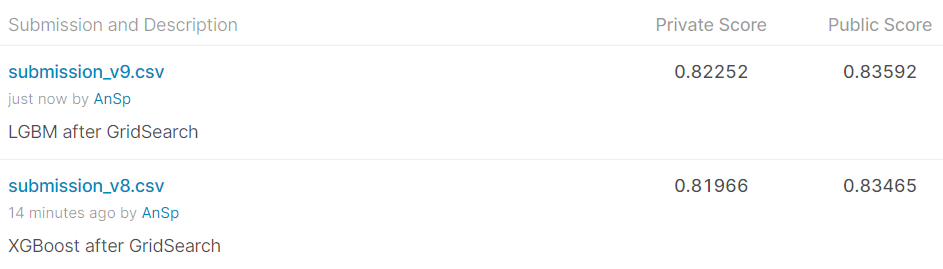

In [98]:
from IPython.display import Image
Image("Results.PNG")

    With LGBM we could get a result not that far away from the top score of AUC: 0.84532.
    We could achieve this by using only 30 of the initial 370 features.
    Our model trained extremly fast (under 1/2 minute run on a normal personal laptop).